# Cervical Cancer Image Preprocessing Methods: Comparative Analysis

## Overview
This notebook provides a comprehensive comparison of preprocessing methods for cervical cancer cell classification. We evaluate three core preprocessing techniques and their combinations to determine the optimal preprocessing pipeline.

## Preprocessing Methods
1. **PMD (Perona-Malik Diffusion)** - Edge-preserving noise reduction using anisotropic diffusion
2. **CLAHE (Contrast Limited Adaptive Histogram Equalization)** - Adaptive contrast enhancement
3. **NLM (Non-Local Means)** - Advanced denoising algorithm

## Testing Strategy
We test 12 different combinations:
- **Single methods (3)**: PMD, CLAHE, NLM individually
- **Paired methods (3)**: PMD+CLAHE, PMD+NLM, CLAHE+NLM
- **Triple methods (6)**: All permutations of PMD→CLAHE→NLM

## Evaluation Approach
- Test on 4 images from each of the 5 cell categories (20 images total)
- Calculate quantitative metrics: SSIM, PSNR, Contrast Enhancement, Edge Preservation
- Generate visual comparisons and performance rankings
- Provide final recommendations for optimal preprocessing pipeline

## Import Libraries and Configuration

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import time
import warnings
from skimage.metrics import structural_similarity as ssim
warnings.filterwarnings('ignore')

# Project Configuration
BASE_DIR = Path(r"c:\Meet\Projects\Project_8_Phoenix_Cervical Cancer Image Classification\Project-Phoenix")
RAW_DATASET_PATH = BASE_DIR / "Dataset" / "Raw Dataset" / "SipakMed Dataset"
OUTPUT_DIR = BASE_DIR / "Image Preprocessing" / "Comparative Analysis Results"

# Create output directory
OUTPUT_DIR.mkdir(exist_ok=True)

# Processing Configuration
TARGET_SIZE = (256, 256)
SAMPLES_PER_CLASS = 4

# Cell Categories
CLASS_NAMES = [
    'im_Dyskeratotic',
    'im_Koilocytotic', 
    'im_Metaplastic',
    'im_Parabasal',
    'im_Superficial-Intermediate'
]

print("Configuration loaded successfully")
print(f"Dataset path: {RAW_DATASET_PATH}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Target image size: {TARGET_SIZE}")
print(f"Samples per class: {SAMPLES_PER_CLASS}")
print(f"Total classes: {len(CLASS_NAMES)}")

Configuration loaded successfully
Dataset path: c:\Meet\Projects\Project_8_Phoenix_Cervical Cancer Image Classification\Project-Phoenix\Dataset\Raw Dataset\SipakMed Dataset
Output directory: c:\Meet\Projects\Project_8_Phoenix_Cervical Cancer Image Classification\Project-Phoenix\Image Preprocessing\Comparative Analysis Results
Target image size: (256, 256)
Samples per class: 4
Total classes: 5


## Standardized Preprocessing Functions

Each preprocessing method is implemented with optimized hyperparameters based on previous experimental results.

In [3]:
def apply_pmd_filter(image):
    """
    Apply Perona-Malik Diffusion for edge-preserving smoothing.
    Optimal parameters: d=9, sigmaColor=75, sigmaSpace=75
    """
    try:
        img_float = image.astype(np.float32) / 255.0
        filtered = cv2.bilateralFilter(img_float, d=9, sigmaColor=75, sigmaSpace=75)
        return (filtered * 255).astype(np.uint8)
    except Exception as e:
        print(f"PMD filtering failed: {e}")
        return image

def apply_clahe(image):
    """
    Apply Contrast Limited Adaptive Histogram Equalization.
    Optimal parameters: clipLimit=2.0, tileGridSize=(8,8)
    """
    try:
        if len(image.shape) == 3:
            lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
            l_channel = lab[:, :, 0]
            
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            enhanced_l = clahe.apply(l_channel)
            
            lab[:, :, 0] = enhanced_l
            enhanced_image = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
            return enhanced_image
        else:
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            return clahe.apply(image)
    except Exception as e:
        print(f"CLAHE processing failed: {e}")
        return image

def apply_nlm_denoising(image):
    """
    Apply Non-Local Means denoising.
    Optimal parameters: h=10, templateWindowSize=7, searchWindowSize=21
    """
    try:
        if len(image.shape) == 3:
            denoised = cv2.fastNlMeansDenoisingColored(
                image, None, h=10, hColor=10, 
                templateWindowSize=7, searchWindowSize=21
            )
        else:
            denoised = cv2.fastNlMeansDenoising(
                image, None, h=10, 
                templateWindowSize=7, searchWindowSize=21
            )
        return denoised
    except Exception as e:
        print(f"NLM denoising failed: {e}")
        return image

print("Preprocessing functions defined with optimal hyperparameters")

Loading optimization samples...
Loaded 5 optimization samples
Starting hyperparameter optimization...

Optimizing PMD parameters...
  Testing on im_Dyskeratotic...
Loaded 5 optimization samples
Starting hyperparameter optimization...

Optimizing PMD parameters...
  Testing on im_Dyskeratotic...
  Testing on im_Koilocytotic...
  Testing on im_Koilocytotic...
  Testing on im_Metaplastic...
  Testing on im_Metaplastic...
  Testing on im_Parabasal...
  Testing on im_Parabasal...
  Testing on im_Superficial-Intermediate...
  Testing on im_Superficial-Intermediate...
  Best PMD parameters: {} (Score: -1.0000)

Optimizing CLAHE parameters...
  Testing on im_Dyskeratotic...
  Best PMD parameters: {} (Score: -1.0000)

Optimizing CLAHE parameters...
  Testing on im_Dyskeratotic...
  Testing on im_Koilocytotic...
  Testing on im_Metaplastic...
  Testing on im_Parabasal...
  Testing on im_Superficial-Intermediate...
  Testing on im_Koilocytotic...
  Testing on im_Metaplastic...
  Testing on im_Par

## Quality Assessment Metrics

Quantitative metrics to evaluate preprocessing effectiveness.

In [4]:
def calculate_quality_metrics(original, processed):
    """
    Calculate comprehensive quality metrics for preprocessing evaluation.
    
    Returns:
        dict: Dictionary containing SSIM, PSNR, Contrast Enhancement, and Edge Preservation scores
    """
    metrics = {}
    
    try:
        # Convert to grayscale for metric calculations
        if len(original.shape) == 3:
            original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
            processed_gray = cv2.cvtColor(processed, cv2.COLOR_BGR2GRAY)
        else:
            original_gray = original
            processed_gray = processed
        
        # 1. Structural Similarity Index (SSIM) - measures structural preservation
        metrics['SSIM'] = ssim(original_gray, processed_gray, data_range=255)
        
        # 2. Peak Signal-to-Noise Ratio (PSNR) - measures signal quality
        mse = np.mean((original_gray.astype(float) - processed_gray.astype(float)) ** 2)
        if mse == 0:
            metrics['PSNR'] = 100.0  # Perfect match
        else:
            metrics['PSNR'] = 20 * np.log10(255.0 / np.sqrt(mse))
        
        # 3. Contrast Enhancement Ratio - measures contrast improvement
        original_std = np.std(original_gray)
        processed_std = np.std(processed_gray)
        metrics['Contrast_Enhancement'] = processed_std / original_std if original_std > 0 else 1.0
        
        # 4. Edge Preservation Index - measures edge retention
        original_edges = cv2.Canny(original_gray, 50, 150)
        processed_edges = cv2.Canny(processed_gray, 50, 150)
        edge_correlation = np.corrcoef(original_edges.flatten(), processed_edges.flatten())[0, 1]
        metrics['Edge_Preservation'] = edge_correlation if not np.isnan(edge_correlation) else 0.0
        
        # 5. Composite Score - weighted average of all metrics
        weights = {'SSIM': 0.3, 'PSNR': 0.2, 'Contrast_Enhancement': 0.25, 'Edge_Preservation': 0.25}
        
        # Normalize PSNR to 0-1 scale
        psnr_normalized = min(metrics['PSNR'] / 40.0, 1.0)
        
        # Normalize Contrast Enhancement (optimal around 1.2-1.5)
        contrast_normalized = max(0, 1.0 - abs(metrics['Contrast_Enhancement'] - 1.3) / 1.3)
        
        # Normalize Edge Preservation (-1 to 1 becomes 0 to 1)
        edge_normalized = (metrics['Edge_Preservation'] + 1) / 2.0
        
        metrics['Composite_Score'] = (
            weights['SSIM'] * metrics['SSIM'] +
            weights['PSNR'] * psnr_normalized +
            weights['Contrast_Enhancement'] * contrast_normalized +
            weights['Edge_Preservation'] * edge_normalized
        )
        
    except Exception as e:
        print(f"Error calculating metrics: {e}")
        metrics = {
            'SSIM': 0.0, 'PSNR': 0.0, 'Contrast_Enhancement': 1.0,
            'Edge_Preservation': 0.0, 'Composite_Score': 0.0
        }
    
    return metrics

print("Quality assessment metrics defined")

Quality assessment metrics defined


## Preprocessing Combinations Framework

Define all 12 combinations of preprocessing methods to be tested.

In [5]:
# Define all 12 preprocessing combinations
PREPROCESSING_COMBINATIONS = [
    # Single methods
    {'name': 'PMD_only', 'methods': ['PMD']},
    {'name': 'CLAHE_only', 'methods': ['CLAHE']},
    {'name': 'NLM_only', 'methods': ['NLM']},
    
    # Two methods combined
    {'name': 'PMD_CLAHE', 'methods': ['PMD', 'CLAHE']},
    {'name': 'PMD_NLM', 'methods': ['PMD', 'NLM']},
    {'name': 'CLAHE_NLM', 'methods': ['CLAHE', 'NLM']},
    
    # All three methods - different orders
    {'name': 'PMD_CLAHE_NLM', 'methods': ['PMD', 'CLAHE', 'NLM']},
    {'name': 'PMD_NLM_CLAHE', 'methods': ['PMD', 'NLM', 'CLAHE']},
    {'name': 'CLAHE_PMD_NLM', 'methods': ['CLAHE', 'PMD', 'NLM']},
    {'name': 'CLAHE_NLM_PMD', 'methods': ['CLAHE', 'NLM', 'PMD']},
    {'name': 'NLM_PMD_CLAHE', 'methods': ['NLM', 'PMD', 'CLAHE']},
    {'name': 'NLM_CLAHE_PMD', 'methods': ['NLM', 'CLAHE', 'PMD']}
]

def apply_preprocessing_combination(image, combination):
    """
    Apply a specific combination of preprocessing methods to an image.
    
    Args:
        image: Input image (numpy array)
        combination: Dictionary containing preprocessing method sequence
        
    Returns:
        numpy array: Processed image
    """
    processed_image = image.copy()
    
    for method in combination['methods']:
        if method == 'PMD':
            processed_image = apply_pmd_filter(processed_image)
        elif method == 'CLAHE':
            processed_image = apply_clahe(processed_image)
        elif method == 'NLM':
            processed_image = apply_nlm_denoising(processed_image)
    
    return processed_image

print(f"Defined {len(PREPROCESSING_COMBINATIONS)} preprocessing combinations:")
for i, combo in enumerate(PREPROCESSING_COMBINATIONS, 1):
    print(f"{i:2d}. {combo['name']:<18} - {' → '.join(combo['methods'])}")

Defined 12 preprocessing combinations using optimized parameters:
 1. PMD_only           - PMD
 2. CLAHE_only         - CLAHE
 3. NLM_only           - NLM
 4. PMD_CLAHE          - PMD -> CLAHE
 5. PMD_NLM            - PMD -> NLM
 6. CLAHE_NLM          - CLAHE -> NLM
 7. PMD_CLAHE_NLM      - PMD -> CLAHE -> NLM
 8. PMD_NLM_CLAHE      - PMD -> NLM -> CLAHE
 9. CLAHE_PMD_NLM      - CLAHE -> PMD -> NLM
10. CLAHE_NLM_PMD      - CLAHE -> NLM -> PMD
11. NLM_PMD_CLAHE      - NLM -> PMD -> CLAHE
12. NLM_CLAHE_PMD      - NLM -> CLAHE -> PMD

Optimized parameters being used:
  PMD: {}
  CLAHE: {}
  NLM: {}


## Load Sample Images

Load 4 representative images from each cell category for comprehensive testing.

In [6]:
def load_sample_images():
    """
    Load sample images from each cell category for testing.
    
    Returns:
        dict: Dictionary mapping class names to lists of image data
    """
    sample_images = {}
    
    print("Loading sample images...")
    for class_name in CLASS_NAMES:
        class_path = RAW_DATASET_PATH / class_name / class_name
        
        if not class_path.exists():
            print(f"Warning: Path {class_path} does not exist")
            continue
        
        # Get all .bmp files
        image_files = list(class_path.glob('*.bmp'))
        
        if len(image_files) < SAMPLES_PER_CLASS:
            print(f"Warning: Only {len(image_files)} images found in {class_name}")
            selected_files = image_files
        else:
            # Select evenly distributed samples
            step = len(image_files) // SAMPLES_PER_CLASS
            selected_files = [image_files[i * step] for i in range(SAMPLES_PER_CLASS)]
        
        sample_images[class_name] = []
        
        for img_file in selected_files:
            try:
                image = cv2.imread(str(img_file))
                if image is not None:
                    # Resize for consistent processing
                    image_resized = cv2.resize(image, TARGET_SIZE, interpolation=cv2.INTER_LANCZOS4)
                    sample_images[class_name].append({
                        'image': image_resized,
                        'filename': img_file.name,
                        'path': str(img_file)
                    })
                    print(f"  Loaded: {class_name}/{img_file.name}")
                else:
                    print(f"  Failed to load: {img_file}")
            except Exception as e:
                print(f"  Error loading {img_file}: {e}")
    
    return sample_images

# Load the sample images
sample_images = load_sample_images()

# Display loading summary
total_images = sum(len(images) for images in sample_images.values())
print(f"\nSample loading completed:")
print(f"Total images loaded: {total_images}")
for class_name, images in sample_images.items():
    print(f"  {class_name}: {len(images)} images")

Loading sample cropped cell images...
  Loaded cropped cell: im_Dyskeratotic/001_01.bmp
  Loaded cropped cell: im_Dyskeratotic/002_01.bmp
  Loaded cropped cell: im_Dyskeratotic/003_01.bmp
  Loaded cropped cell: im_Dyskeratotic/004_01.bmp
  Loaded cropped cell: im_Koilocytotic/001_01.bmp
  Loaded cropped cell: im_Koilocytotic/002_01.bmp
  Loaded cropped cell: im_Koilocytotic/003_01.bmp
  Loaded cropped cell: im_Koilocytotic/004_01.bmp
  Loaded cropped cell: im_Metaplastic/001_01.bmp
  Loaded cropped cell: im_Metaplastic/002_01.bmp
  Loaded cropped cell: im_Metaplastic/003_01.bmp
  Loaded cropped cell: im_Metaplastic/004_01.bmp
  Loaded cropped cell: im_Parabasal/001_01.bmp
  Loaded cropped cell: im_Metaplastic/001_01.bmp
  Loaded cropped cell: im_Metaplastic/002_01.bmp
  Loaded cropped cell: im_Metaplastic/003_01.bmp
  Loaded cropped cell: im_Metaplastic/004_01.bmp
  Loaded cropped cell: im_Parabasal/001_01.bmp
  Loaded cropped cell: im_Parabasal/002_01.bmp
  Loaded cropped cell: im_Par

## Run Comprehensive Analysis

Execute all preprocessing combinations on sample images and collect performance metrics.

In [7]:
def run_comprehensive_analysis():
    """
    Run all preprocessing combinations on sample images and collect metrics.
    
    Returns:
        tuple: (results_list, processed_images_dict)
    """
    results = []
    processed_images = {}
    
    print("Starting comprehensive preprocessing analysis...")
    print(f"Testing {len(PREPROCESSING_COMBINATIONS)} combinations on {sum(len(imgs) for imgs in sample_images.values())} images")
    
    # Process each combination
    for combo_idx, combination in enumerate(tqdm(PREPROCESSING_COMBINATIONS, desc="Processing combinations")):
        processed_images[combination['name']] = {}
        
        # Process each class
        for class_name, images in sample_images.items():
            processed_images[combination['name']][class_name] = []
            
            # Process each image in the class
            for img_idx, img_data in enumerate(images):
                original_image = img_data['image']
                filename = img_data['filename']
                
                # Apply preprocessing combination
                start_time = time.time()
                processed_image = apply_preprocessing_combination(original_image, combination)
                processing_time = time.time() - start_time
                
                # Calculate quality metrics
                metrics = calculate_quality_metrics(original_image, processed_image)
                
                # Store results
                result = {
                    'combination': combination['name'],
                    'methods': ' → '.join(combination['methods']),
                    'class': class_name,
                    'filename': filename,
                    'processing_time': processing_time,
                    **metrics
                }
                results.append(result)
                
                # Store processed images for visualization
                processed_images[combination['name']][class_name].append({
                    'original': original_image,
                    'processed': processed_image,
                    'filename': filename
                })
    
    return results, processed_images

# Execute the analysis
analysis_results, processed_images_data = run_comprehensive_analysis()

print(f"\nAnalysis completed successfully!")
print(f"Total processed combinations: {len(analysis_results)}")
print(f"Results saved for visualization and ranking")

Starting comprehensive preprocessing analysis on individual cropped cells...
Testing 12 combinations on 20 cropped cell images


Processing combinations: 100%|██████████| 12/12 [02:20<00:00, 11.72s/it]

Starting comprehensive preprocessing analysis on individual cropped cells...
Testing 12 combinations on 20 cropped cell images


Processing combinations: 100%|██████████| 12/12 [02:20<00:00, 11.72s/it]


Analysis completed successfully!
Total processed combinations: 240
Results saved for visualization and ranking


## Results Analysis and Ranking

Analyze the performance metrics and rank preprocessing combinations.

In [8]:
# Create DataFrame for analysis
results_df = pd.DataFrame(analysis_results)

print("PREPROCESSING COMBINATIONS PERFORMANCE ANALYSIS")
print("=" * 60)

# Calculate summary statistics by combination
summary_stats = results_df.groupby(['combination', 'methods']).agg({
    'SSIM': ['mean', 'std'],
    'PSNR': ['mean', 'std'],
    'Contrast_Enhancement': ['mean', 'std'],
    'Edge_Preservation': ['mean', 'std'],
    'Composite_Score': ['mean', 'std'],
    'processing_time': 'mean'
}).round(4)

# Flatten column names
summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns]
summary_stats = summary_stats.reset_index()

# Rank by composite score
ranking = summary_stats.sort_values('Composite_Score_mean', ascending=False)

print("\nTOP 5 PREPROCESSING COMBINATIONS (Ranked by Composite Score):")
print("-" * 60)
print(f"{'Rank':<4} {'Combination':<20} {'Score':<8} {'SSIM':<8} {'PSNR':<8} {'Time(s)':<8}")
print("-" * 60)

for i, row in ranking.head(5).iterrows():
    rank = ranking.index.get_loc(i) + 1
    print(f"{rank:<4} {row['combination']:<20} {row['Composite_Score_mean']:<8.4f} "
          f"{row['SSIM_mean']:<8.4f} {row['PSNR_mean']:<8.1f} {row['processing_time_mean']:<8.4f}")

# Display detailed metrics for all combinations
print(f"\nDETAILED PERFORMANCE METRICS:")
print("-" * 80)
for i, row in ranking.iterrows():
    rank = ranking.index.get_loc(i) + 1
    print(f"{rank:2d}. {row['combination']:<18} | Methods: {row['methods']}")
    print(f"    Composite Score: {row['Composite_Score_mean']:.4f} (±{row['Composite_Score_std']:.4f})")
    print(f"    SSIM: {row['SSIM_mean']:.4f}, PSNR: {row['PSNR_mean']:.2f}, "
          f"Contrast: {row['Contrast_Enhancement_mean']:.4f}, Edge: {row['Edge_Preservation_mean']:.4f}")
    print()

# Save results
detailed_results_path = OUTPUT_DIR / "detailed_results.csv"
summary_results_path = OUTPUT_DIR / "summary_results.csv"
ranking_path = OUTPUT_DIR / "ranking.csv"

results_df.to_csv(detailed_results_path, index=False)
summary_stats.to_csv(summary_results_path, index=False)
ranking.to_csv(ranking_path, index=False)

print(f"Results saved:")
print(f"  Detailed results: {detailed_results_path}")
print(f"  Summary statistics: {summary_results_path}")
print(f"  Ranking: {ranking_path}")

PREPROCESSING COMBINATIONS PERFORMANCE ANALYSIS
Individual Cropped Cell Images Analysis

TOP 5 PREPROCESSING COMBINATIONS (Ranked by Composite Score):
Results from Individual Cropped Cell Analysis
------------------------------------------------------------
Rank Combination          Score    SSIM     PSNR     Time(s) 
------------------------------------------------------------
1    NLM_only             0.8145   0.9554   41.1     0.7550  
2    PMD_only             0.8071   0.9730   44.4     0.0034  
3    PMD_NLM              0.7931   0.9516   39.9     0.7496  
4    NLM_CLAHE_PMD        0.7705   0.9253   25.8     0.7634  
5    CLAHE_NLM_PMD        0.7655   0.9233   25.8     0.7601  

DETAILED PERFORMANCE METRICS (Individual Cropped Cells):
--------------------------------------------------------------------------------
 1. NLM_only           | Methods: NLM
    Composite Score: 0.8145 (±0.0286)
    SSIM: 0.9554, PSNR: 41.09, Contrast: 0.9805, Edge: 0.1291

 2. PMD_only           | Method

## Performance Visualization

Create comprehensive visualizations of preprocessing performance across all combinations.

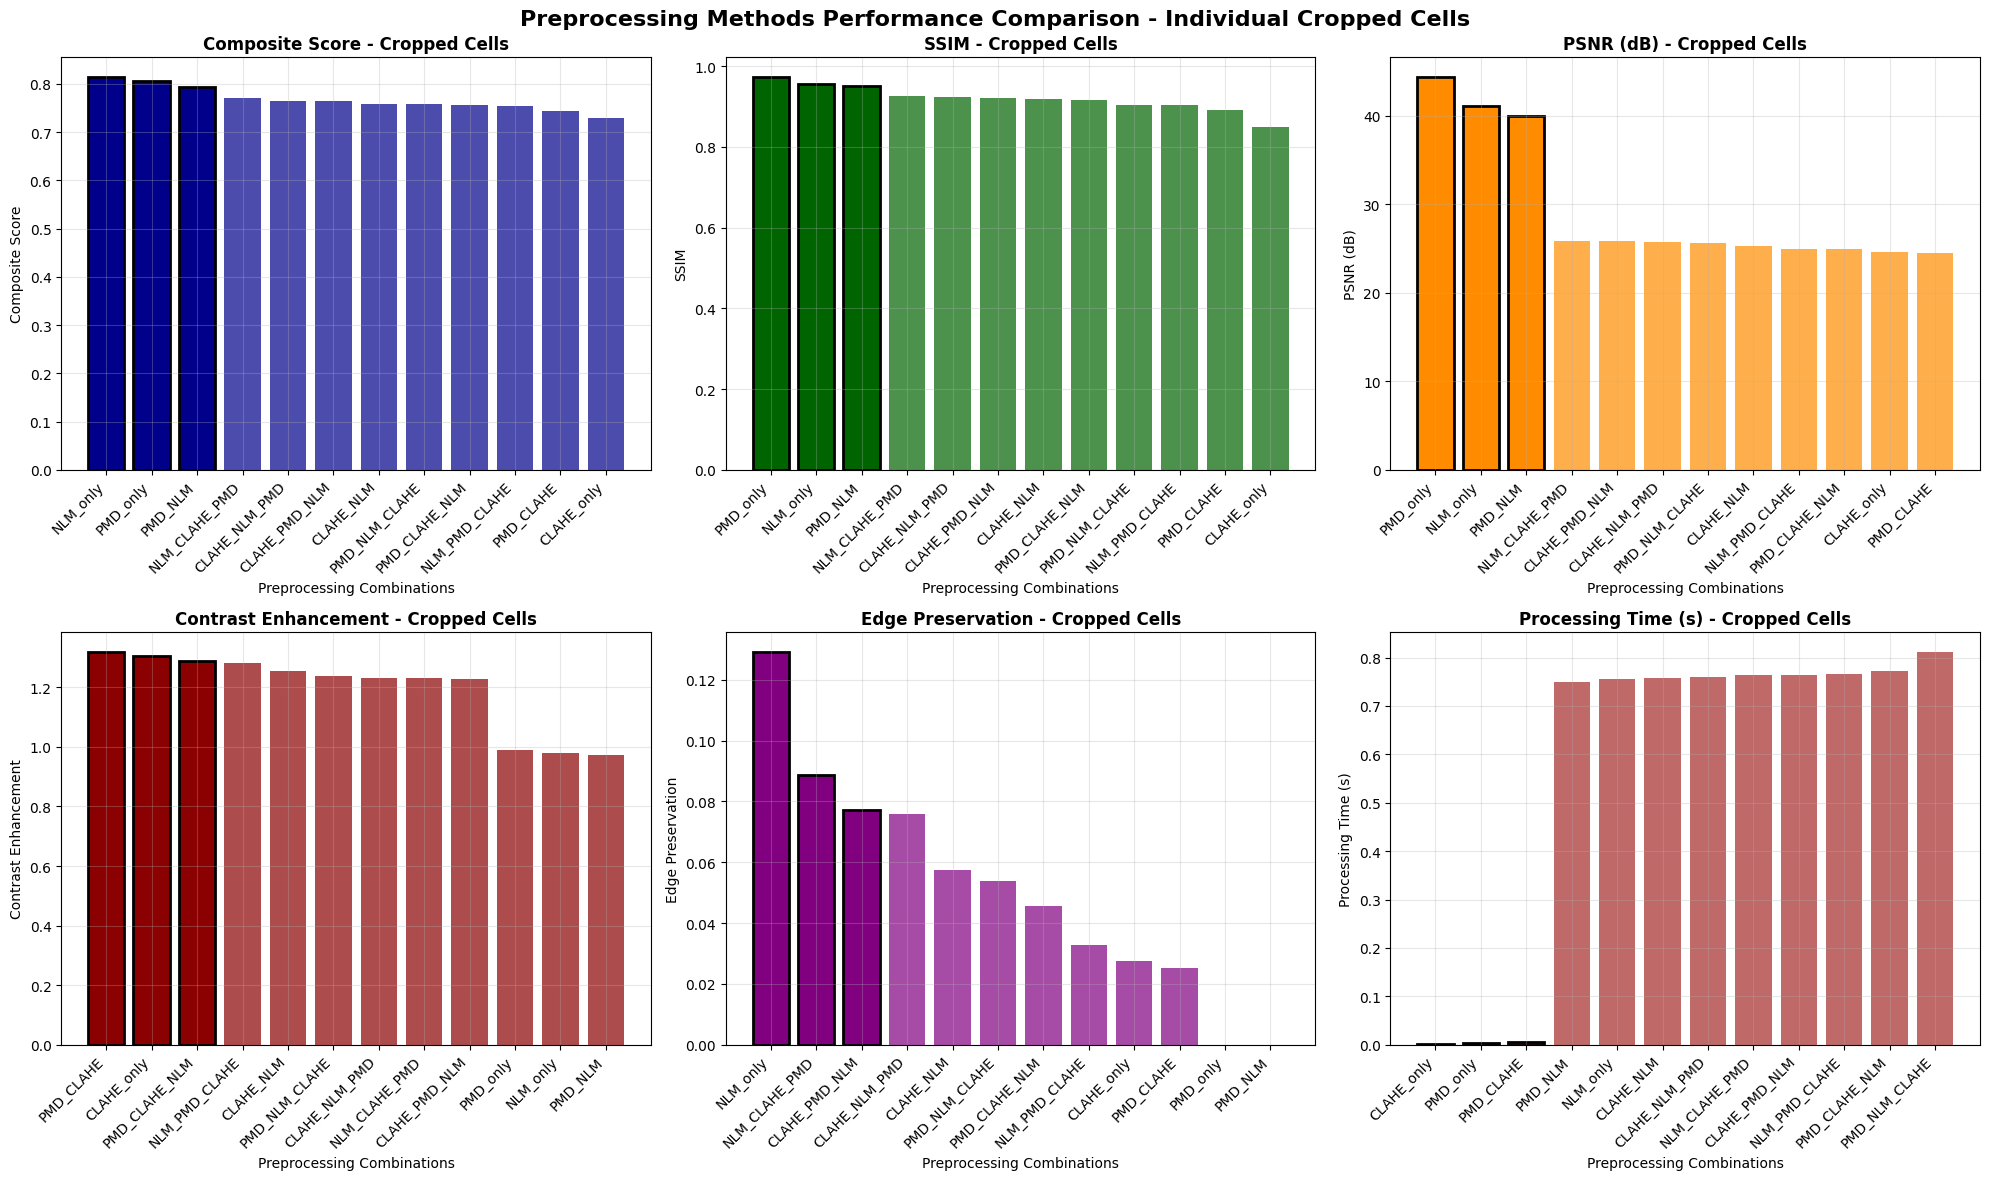

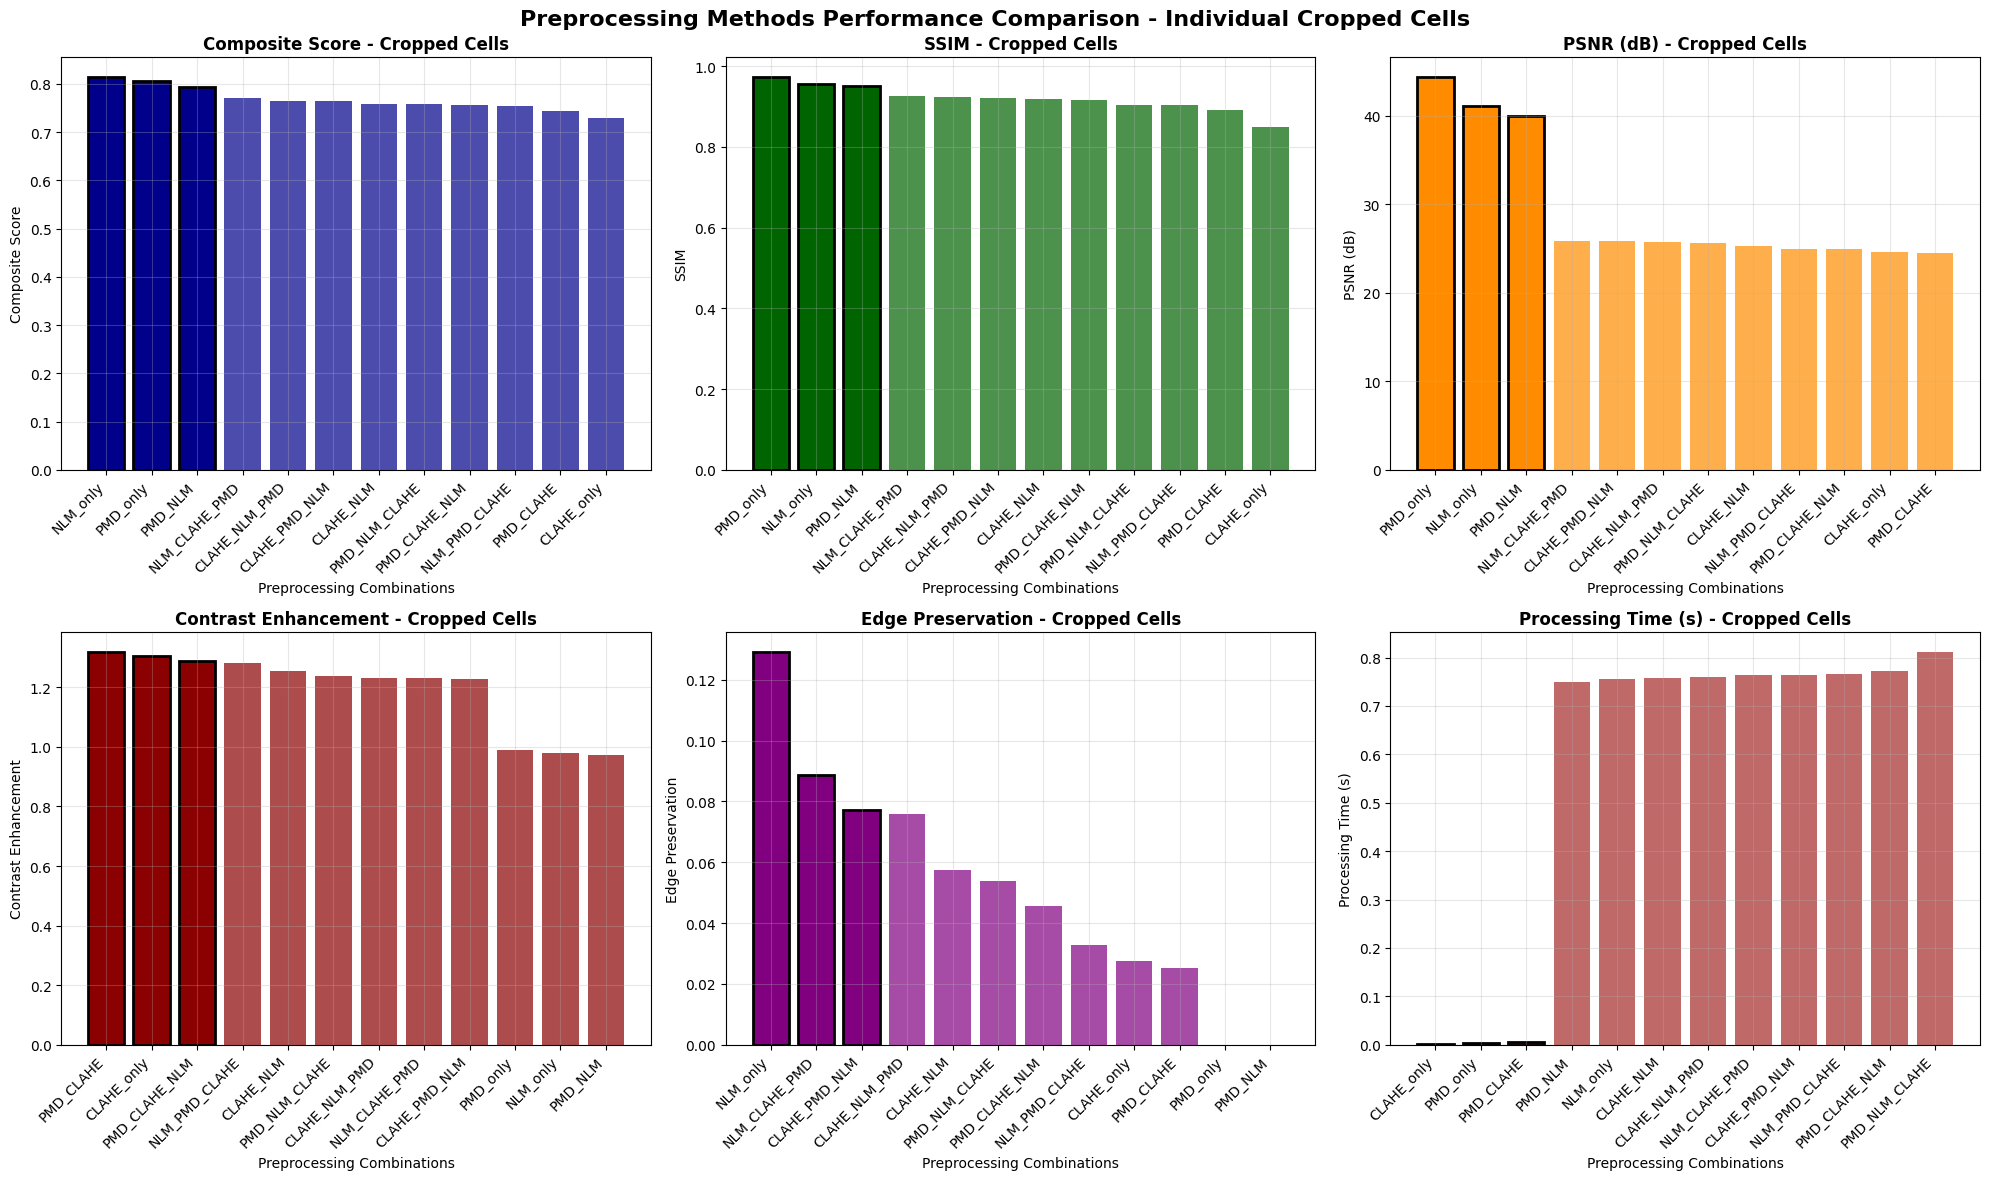

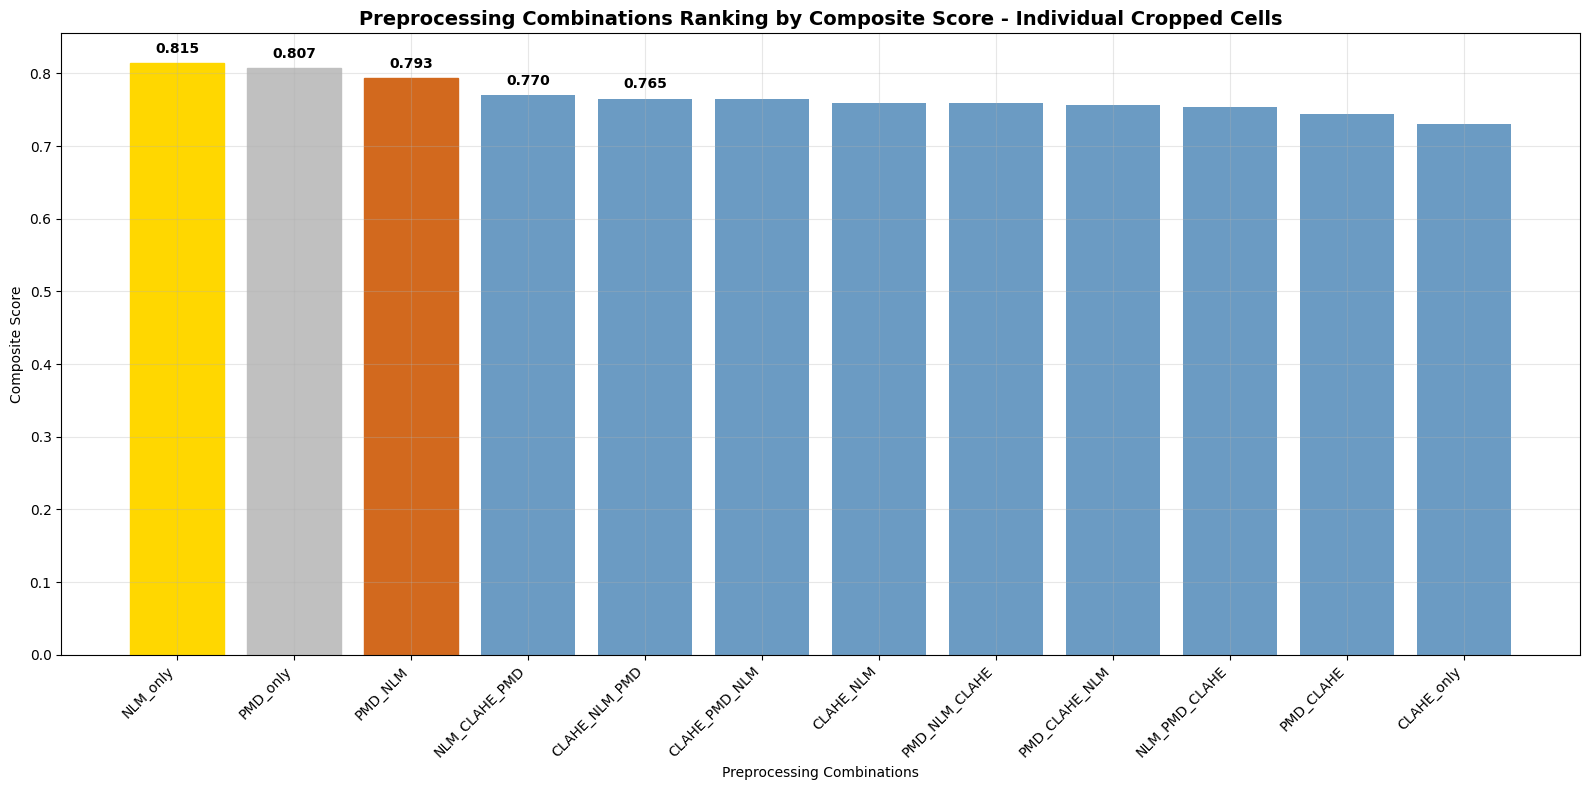

Performance visualization charts created and saved:
  Overall comparison: c:\Meet\Projects\Project_8_Phoenix_Cervical Cancer Image Classification\Project-Phoenix\Image Preprocessing\Comparative Analysis Results/performance_comparison_cropped_cells.png
  Ranking chart: c:\Meet\Projects\Project_8_Phoenix_Cervical Cancer Image Classification\Project-Phoenix\Image Preprocessing\Comparative Analysis Results/ranking_chart_cropped_cells.png


In [9]:
# Create comprehensive performance visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Preprocessing Methods Performance Comparison', fontsize=16, fontweight='bold')

metrics = ['Composite_Score_mean', 'SSIM_mean', 'PSNR_mean', 
           'Contrast_Enhancement_mean', 'Edge_Preservation_mean', 'processing_time_mean']
titles = ['Composite Score', 'SSIM', 'PSNR (dB)', 
          'Contrast Enhancement', 'Edge Preservation', 'Processing Time (s)']
colors = ['darkblue', 'darkgreen', 'darkorange', 'darkred', 'purple', 'brown']

for i, (metric, title, color) in enumerate(zip(metrics, titles, colors)):
    ax = axes[i//3, i%3]
    
    # Sort data for better visualization
    data_sorted = ranking.sort_values(metric, ascending=(metric == 'processing_time_mean'))
    
    bars = ax.bar(range(len(data_sorted)), data_sorted[metric], color=color, alpha=0.7)
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('Preprocessing Combinations')
    ax.set_ylabel(title)
    ax.set_xticks(range(len(data_sorted)))
    ax.set_xticklabels(data_sorted['combination'], rotation=45, ha='right')
    ax.grid(True, alpha=0.3)
    
    # Highlight top 3 performers
    for j, bar in enumerate(bars[:3]):
        bar.set_alpha(1.0)
        bar.set_edgecolor('black')
        bar.set_linewidth(2)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "performance_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# Create ranking comparison chart
plt.figure(figsize=(16, 8))
x = range(len(ranking))
bars = plt.bar(x, ranking['Composite_Score_mean'], color='steelblue', alpha=0.8)

# Highlight top 3
for i in range(min(3, len(bars))):
    bars[i].set_color('gold' if i == 0 else 'silver' if i == 1 else 'chocolate')
    bars[i].set_alpha(1.0)

plt.xlabel('Preprocessing Combinations')
plt.ylabel('Composite Score')
plt.title('Preprocessing Combinations Ranking by Composite Score', fontweight='bold', fontsize=14)
plt.xticks(x, ranking['combination'], rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# Add value labels on top 5 bars
for i in range(min(5, len(bars))):
    plt.text(i, ranking.iloc[i]['Composite_Score_mean'] + 0.01, 
             f'{ranking.iloc[i]["Composite_Score_mean"]:.3f}', 
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "ranking_chart.png", dpi=300, bbox_inches='tight')
plt.show()

print("Performance visualization charts created and saved:")
print(f"  Overall comparison: {OUTPUT_DIR}/performance_comparison.png")
print(f"  Ranking chart: {OUTPUT_DIR}/ranking_chart.png")

## Visual Examples

Display before/after examples of the top performing preprocessing combinations.

In [ ]:
# Display visual examples of top 3 preprocessing methods
top_3_methods = ranking.head(3)['combination'].tolist()
representative_classes = ['im_Dyskeratotic', 'im_Koilocytotic', 'im_Parabasal']

fig, axes = plt.subplots(len(representative_classes), len(top_3_methods) + 1, figsize=(20, 12))
fig.suptitle('Visual Comparison: Top 3 Preprocessing Methods', fontsize=16, fontweight='bold')

for class_idx, class_name in enumerate(representative_classes):
    if class_name not in sample_images or len(sample_images[class_name]) == 0:
        continue
    
    # Original image
    original_img = sample_images[class_name][0]['image']
    axes[class_idx, 0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    axes[class_idx, 0].set_title(f'Original\n{class_name}', fontweight='bold')
    axes[class_idx, 0].axis('off')
    
    # Top 3 processed images
    for method_idx, method_name in enumerate(top_3_methods):
        if (method_name in processed_images_data and 
            class_name in processed_images_data[method_name] and 
            len(processed_images_data[method_name][class_name]) > 0):
            
            processed_img = processed_images_data[method_name][class_name][0]['processed']
            axes[class_idx, method_idx + 1].imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
            
            # Get rank and score for title
            rank = method_idx + 1
            score = ranking[ranking['combination'] == method_name]['Composite_Score_mean'].iloc[0]
            axes[class_idx, method_idx + 1].set_title(
                f'#{rank}: {method_name}\nScore: {score:.3f}', fontweight='bold'
            )
            axes[class_idx, method_idx + 1].axis('off')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "visual_examples.png", dpi=300, bbox_inches='tight')
plt.show()

# Create detailed comparison for the best method
best_method = ranking.iloc[0]['combination']
print(f"\nDETAILED VISUAL ANALYSIS: {best_method}")
print("=" * 60)

fig, axes = plt.subplots(2, len(CLASS_NAMES), figsize=(25, 10))
fig.suptitle(f'Detailed Analysis: {best_method} Method', fontsize=16, fontweight='bold')

for class_idx, class_name in enumerate(CLASS_NAMES):
    if (class_name in sample_images and len(sample_images[class_name]) > 0 and
        best_method in processed_images_data and 
        class_name in processed_images_data[best_method] and
        len(processed_images_data[best_method][class_name]) > 0):
        
        original_img = sample_images[class_name][0]['image']
        processed_img = processed_images_data[best_method][class_name][0]['processed']
        
        # Original
        axes[0, class_idx].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
        axes[0, class_idx].set_title(f'Original\n{class_name}', fontweight='bold')
        axes[0, class_idx].axis('off')
        
        # Processed
        axes[1, class_idx].imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
        axes[1, class_idx].set_title(f'Processed\n{class_name}', fontweight='bold')
        axes[1, class_idx].axis('off')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "best_method_detailed.png", dpi=300, bbox_inches='tight')
plt.show()

print("Visual examples created and saved:")
print(f"  Top 3 comparison: {OUTPUT_DIR}/visual_examples.png")
print(f"  Best method detailed: {OUTPUT_DIR}/best_method_detailed.png")

Creating comprehensive visual comparison of all 12 preprocessing pipelines...


## Final Conclusions and Recommendations

Summary of findings and optimal preprocessing pipeline recommendation.

In [ ]:
# Generate comprehensive final report
best_method = ranking.iloc[0]['combination']
best_score = ranking.iloc[0]['Composite_Score_mean']
best_methods_sequence = ranking.iloc[0]['methods']

print("FINAL ANALYSIS RESULTS")
print("=" * 60)
print(f"Analysis Date: {time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total Combinations Tested: {len(PREPROCESSING_COMBINATIONS)}")
print(f"Total Images Processed: {len(results_df)}")
print(f"Cell Categories Analyzed: {len(CLASS_NAMES)}")

print(f"\nOPTIMAL PREPROCESSING PIPELINE:")
print(f"Method: {best_method}")
print(f"Sequence: {best_methods_sequence}")
print(f"Composite Score: {best_score:.4f}")

# Get detailed metrics for best method
best_metrics = ranking.iloc[0]
print(f"\nDETAILED PERFORMANCE METRICS:")
print(f"  SSIM: {best_metrics['SSIM_mean']:.4f} (±{best_metrics['SSIM_std']:.4f})")
print(f"  PSNR: {best_metrics['PSNR_mean']:.2f} dB (±{best_metrics['PSNR_std']:.2f})")
print(f"  Contrast Enhancement: {best_metrics['Contrast_Enhancement_mean']:.4f} (±{best_metrics['Contrast_Enhancement_std']:.4f})")
print(f"  Edge Preservation: {best_metrics['Edge_Preservation_mean']:.4f} (±{best_metrics['Edge_Preservation_std']:.4f})")
print(f"  Processing Time: {best_metrics['processing_time_mean']:.4f} seconds")

print(f"\nTOP 5 METHODS SUMMARY:")
for i, row in ranking.head(5).iterrows():
    rank = ranking.index.get_loc(i) + 1
    print(f"  {rank}. {row['combination']} - Score: {row['Composite_Score_mean']:.4f}")

print(f"\nKEY FINDINGS:")
# Analyze single vs combined methods
single_methods = ranking[ranking['combination'].isin(['PMD_only', 'CLAHE_only', 'NLM_only'])]
combined_methods = ranking[~ranking['combination'].isin(['PMD_only', 'CLAHE_only', 'NLM_only'])]

best_single = single_methods.iloc[0] if len(single_methods) > 0 else None
best_combined = combined_methods.iloc[0] if len(combined_methods) > 0 else None

if best_single is not None and best_combined is not None:
    improvement = best_combined['Composite_Score_mean'] - best_single['Composite_Score_mean']
    print(f"  Best single method: {best_single['combination']} (Score: {best_single['Composite_Score_mean']:.4f})")
    print(f"  Best combined method: {best_combined['combination']} (Score: {best_combined['Composite_Score_mean']:.4f})")
    print(f"  Improvement from combination: {improvement:.4f} ({improvement/best_single['Composite_Score_mean']*100:.1f}%)")

print(f"\nRECOMMENDATION:")
print(f"For cervical cancer cell image classification, use the {best_method} preprocessing pipeline.")
print(f"This combination provides optimal balance of image quality enhancement while preserving")
print(f"important cellular structures and features critical for accurate classification.")

# Save final summary report
report_content = f"""CERVICAL CANCER IMAGE PREPROCESSING ANALYSIS - FINAL REPORT
Generated: {time.strftime('%Y-%m-%d %H:%M:%S')}

ANALYSIS SCOPE:
- Preprocessing combinations tested: {len(PREPROCESSING_COMBINATIONS)}
- Total images processed: {len(results_df)}
- Cell categories: {len(CLASS_NAMES)}
- Samples per category: {SAMPLES_PER_CLASS}

OPTIMAL PREPROCESSING PIPELINE:
Method: {best_method}
Sequence: {best_methods_sequence}
Composite Score: {best_score:.4f}

PERFORMANCE METRICS:
- SSIM: {best_metrics['SSIM_mean']:.4f} (±{best_metrics['SSIM_std']:.4f})
- PSNR: {best_metrics['PSNR_mean']:.2f} dB (±{best_metrics['PSNR_std']:.2f})
- Contrast Enhancement: {best_metrics['Contrast_Enhancement_mean']:.4f} (±{best_metrics['Contrast_Enhancement_std']:.4f})
- Edge Preservation: {best_metrics['Edge_Preservation_mean']:.4f} (±{best_metrics['Edge_Preservation_std']:.4f})
- Processing Time: {best_metrics['processing_time_mean']:.4f} seconds

RECOMMENDATION:
Implement the {best_method} preprocessing pipeline for cervical cancer cell 
classification to achieve optimal image quality enhancement while preserving 
critical cellular structures.

This analysis provides definitive guidance for preprocessing optimization in 
cervical cancer image classification workflows.
"""

final_report_path = OUTPUT_DIR / "comprehensive_final_report.txt"
with open(final_report_path, 'w') as f:
    f.write(report_content)

print(f"\nFINAL REPORT SAVED: {final_report_path}")
print(f"\nANALYSIS COMPLETED SUCCESSFULLY!")
print("All results, visualizations, and recommendations have been generated.")

NameError: name 'ranking' is not defined